<a href="https://colab.research.google.com/github/rahiakela/gans-in-action/blob/part-2-advanced-topics-in-gans/7-semi_supervised_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semi-Supervised GAN(SGAN)


Semi-supervised learning is one of the most promising areas of practical application of GANs. 

Unlike supervised learning, in which we need a label for every example in our
dataset, and unsupervised learning, in which no labels are used, semi-supervised
learning has a class label for only a small subset of the training dataset. 

By internalizing hidden structures in the data, semi-supervised learning strives to generalize from the small subset of labeled data points to effectively classify new, previously unseen examples. 

Importantly, for semi-supervised learning to work, the labeled and unlabeled
data must come from the same underlying distribution.

Interestingly, semi-supervised learning may also be one of the closest machine
learning analogs to the way humans learn. 

When schoolchildren learn to read and write, the teacher does not have to take them on a road trip to see tens of thousands of examples of letters and numbers, ask them to identify these symbols, and correct them as needed—similarly to the way a supervised learning algorithm would operate.
Instead, a single set of examples is all that is needed for children to learn letters and numerals and then be able to recognize them regardless of font, size, angle, lighting conditions, and many other factors. Semi-supervised learning aims to teach machines in a similarly efficient manner.

Serving as a source of additional information that can be used for training, generative models proved useful in improving the accuracy of semi-supervised models. Unsurprisingly, GANs have proven the most promising.

## What is a Semi-Supervised GAN?

Semi-Supervised GAN (SGAN) is a Generative Adversarial Network whose Discriminator is a multiclass classifier. Instead of distinguishing between only two classes (real and fake), it learns to distinguish between N + 1 classes, where N is the number of classes in the training dataset, with one added for the fake examples produced by the Generator.

For example, the MNIST dataset of handwritten digits has 10 labels (one label for each numeral, 0 to 9), so the SGAN Discriminator trained on this dataset would predict between 10 + 1 = 11 classes. 

In our implementation, the output of the SGAN Discriminator will be represented as a vector of 10 class probabilities (that sum up to 1.0) plus another probability that represents whether the image is real or fake.


<img src='https://github.com/rahiakela/img-repo/blob/master/gans-in-action/sgan-architecture.png?raw=1' width='800'/>

---

In this Semi-Supervised GAN, the Generator takes in a random noise
vector z and produces a fake example x*. The Discriminator receives three kinds of data inputs: fake data from the Generator, real unlabeled examples x, and real labeled examples (x, y), where y is the label corresponding to the given example. The Discriminator then outputs a classification; its goal is to distinguish fake examples from the real ones and, for the real examples, identify the correct class. Notice that the portion of examples with labels is much smaller than the portion of the unlabeled data. In practice, the contrast is even starker than the one shown, with labeled data forming only a tiny fraction (often as little as 1–2%) of the training data.

---

The task of distinguishing between multiple classes not only
impacts the Discriminator itself, but also adds complexity to the SGAN architecture, its training process, and its training objectives, as compared to the traditional GAN.






## Architecture

The SGAN Generator’s purpose is the same as in the original GAN: it takes in a vector of random numbers and produces fake examples whose goal is to be indistinguishable from the training dataset—no change here.

The SGAN Discriminator, however, diverges considerably from the original GAN
implementation. Instead of two, it receives three kinds of inputs: fake examples produced by the Generator (x*), real examples without labels from the training dataset (x), and real examples with labels from the training dataset (x, y), where y denotes the label for the given example x.Instead of binary classification, the SGAN Discriminator’s goal is to correctly categorize the input example into its corresponding class if the example is real, or reject the example as fake (which can be thought of as a special additional class).

<img src='https://github.com/rahiakela/img-repo/blob/master/gans-in-action/sgan-network-table.png?raw=1' width='800'/>



## Training process

In a regular GAN, we train the Discriminator by computing the loss for
$D(x)$ and $D(x*)$ and backpropagating the total loss to update the Discriminator’s trainable parameters to minimize the loss. The Generator is trained by backpropagating the Discriminator’s loss for D(x*), seeking to maximize it, so that the fake examples it synthesizes are misclassified as real.

To train the SGAN, in addition to D(x) and D(x*), we also have to compute the loss for the supervised training examples: D((x, y)). These losses correspond to the dual learning objective that the SGAN Discriminator has to grapple with: distinguishing real examples from the fake ones while also learning to classify real examples to their correct classes.

## Training objective

All the GAN generative models goal is to produce realistic-looking data samples; hence, the Generator network has been of primary interest. The main purpose of the Discriminator network has been to help the Generator improve the quality of images it produces. 

**At the end of the training, we often disregard the Discriminator and use only the fully trained Generator to create realistic-looking synthetic data.**

In contrast, in a SGAN, we care primarily about the Discriminator. The goal of the training process is to make this network into a semi-supervised classifier whose accuracy is as close as possible to a fully supervised classifier (one that has labels available for each example in the training dataset), while using only a small fraction of the labels. The Generator’s goal is to aid this process by serving as a source of additional information (the fake data it produces) that helps the Generator learn the relevant patterns in the data, enhancing its classification accuracy. 

**At the end of the training, the Generator gets discarded, and we use the trained Discriminator as a classifier.**

## Implementing a Semi-Supervised GAN

We implement an SGAN model that learns to classify handwritten digits in the MNIST dataset by using only 100 training examples. At the end of it, we compare the model’s classification accuracy to an equivalent fully supervised model to see for ourselves the improvement achieved by semi-supervised learning.

<img src='https://github.com/rahiakela/img-repo/blob/master/gans-in-action/sgan-diagram.png?raw=1' width='800'/>

The Generator turns random noise into fake examples. The Discriminator receives real images with labels (x, y), real images without labels (x), and fake images produced by the Generator (x*). To distinguish real examples from fake ones, the Discriminator uses the sigmoid function. To distinguish between the real classes, the Discriminator uses the
softmax function.


---

To solve the multiclass classification problem of distinguishing between the real labels, the Discriminator uses the softmax function, which gives probability distribution over a specified number of classes—in our case, 10. The higher the probability assigned to a given label, the more confident the Discriminator is that the example
belongs to the given class. To compute the classification error, we use cross-entropy loss, which measures the difference between the output probabilities and the target,
one-hot-encoded labels.

To output the real-versus-fake probability, the Discriminator uses the sigmoid activation function and trains its parameters by backpropagating the binary cross-entropy loss.



### Setup

In [27]:
import tensorflow as tf

from tensorflow.keras.layers import (Activation, BatchNormalization, Concatenate, Dense, Dropout,
                                     Flatten, Input, Lambda, Reshape, LeakyReLU, Conv2D, Conv2DTranspose)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We also specify the input image size, the size of the noise vector $z$, and the number of the real classes for the semi-supervised classification (one for each numeral our Discriminator will learn to identify), as shown in the following listing.

In [28]:
# Model input dimensions
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

# Number of classes in the dataset
num_classes = 10

### The dataset

Although the MNIST training dataset has `50,000` labeled training images, we will use only a small fraction of them (specified by the `num_labeled` parameter) for training
and pretend that all the remaining ones are unlabeled. We accomplish this by sampling only from the first num_labeled images when generating batches of labeled data and from the remaining `(50,000 – num_labeled)` images when generating batches of unlabeled examples.

The Dataset object also provides a function to return all the
`num_labeled` training examples along with their labels as well as a function to return all `10,000` labeled test images in the MNIST dataset. After training, we will use the test set to evaluate how well the model’s classifications generalize to previously unseen examples.

In [29]:
class Dataset:
  def __init__(self, num_labeled):

      # Number labeled examples to use for training
      self.num_labeled = num_labeled

      # Load the MNIST dataset
      (self.x_train, self.y_train), (self.x_test,
                                      self.y_test) = mnist.load_data()

      def preprocess_imgs(x):
          # Rescale [0, 255] grayscale pixel values to [-1, 1]
          x = (x.astype(np.float32) - 127.5) / 127.5
          # Expand image dimensions to width x height x channels
          x = np.expand_dims(x, axis=3)
          return x

      def preprocess_labels(y):
          return y.reshape(-1, 1)

      # Training data
      self.x_train = preprocess_imgs(self.x_train)
      self.y_train = preprocess_labels(self.y_train)

      # Testing data
      self.x_test = preprocess_imgs(self.x_test)
      self.y_test = preprocess_labels(self.y_test)

  def batch_labeled(self, batch_size):
      # Get a random batch of labeled images and their labels
      idx = np.random.randint(0, self.num_labeled, batch_size)
      imgs = self.x_train[idx]
      labels = self.y_train[idx]
      return imgs, labels

  def batch_unlabeled(self, batch_size):
      # Get a random batch of unlabeled images
      idx = np.random.randint(self.num_labeled, self.x_train.shape[0],
                              batch_size)
      imgs = self.x_train[idx]
      return imgs

  def training_set(self):
      x_train = self.x_train[range(self.num_labeled)]
      y_train = self.y_train[range(self.num_labeled)]
      return x_train, y_train

  def test_set(self):
      return self.x_test, self.y_test

We will pretend that we have only 100 labeled MNIST images for training:

In [30]:
# Number of labeled examples to use (rest will be used as unlabeled)
num_labeled = 100

dataset = Dataset(num_labeled)
print(dataset.num_labeled)

100


### The Generator

The Generator network is the same as the one we implemented for the DCGAN. Using transposed convolution layers, the Generator transforms the input random noise vector into 28 × 28 × 1 image; see the following listing.

In [31]:
def build_generator(z_dim):
  model = Sequential()

  # Reshape input into 7x7x256 tensor via a fully connected layer
  model.add(Dense(256 * 7 * 7, input_dim=z_dim))
  model.add(Reshape((7, 7, 256)))

  # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
  model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
  # Batch normalization
  model.add(BatchNormalization())
  # Leaky ReLU activation
  model.add(LeakyReLU(alpha=0.01))

  # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
  model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
  # Batch normalization
  model.add(BatchNormalization())
  # Leaky ReLU activation
  model.add(LeakyReLU(alpha=0.01))

  # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
  model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))

  # utput layer with tanh activation
  model.add(Activation('tanh'))

  return model

### The Discriminator

The Discriminator is the most complex part of the SGAN model. Recall that the SGAN Discriminator has a dual objective:

- Distinguish real examples from fake ones. For this, the SGAN Discriminator uses the sigmoid function, outputting a single output probability for binary classification.
- For the real examples, accurately classify their label. For this, the SGAN Discriminator uses the softmax function, outputting a vector of probabilities, one for each of the target classes.

**The core discriminator network**
We add a dropout, a regularization technique that helps prevent
overfitting by randomly dropping neurons and their connections from the neural network during training. This forces the remaining neurons to reduce their codependence and develop a more general representation of the underlying data. The fraction of the neurons to be randomly dropped is specified by the rate parameter, which is set to 0.5 in our implementation: model.add(Dropout(0.5)). We add dropout because of the increased complexity of the SGAN classification task and to improve the model’s ability to generalize from only 100 labeled examples.

In [32]:
def build_discriminator_net(img_shape):
  model = Sequential()

  # Convolutional layer, from 28x28x1 into 14x14x32 tensor
  model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
  # Leaky ReLU activation
  model.add(LeakyReLU(alpha=0.01))

  # Convolutional layer, from 14x14x32 into 7x7x64 tensor
  model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
  # Batch normalization
  model.add(BatchNormalization())
  # Leaky ReLU activation
  model.add(LeakyReLU(alpha=0.01))

  # Convolutional layer, from 7x7x64 tensor into 3x3x128 tensor
  model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
  # Batch normalization
  model.add(BatchNormalization())
  # Leaky ReLU activation
  model.add(LeakyReLU(alpha=0.01))

  # Droupout
  model.add(Dropout(0.5))

  # Flatten the tensor
  model.add(Flatten())

  # Fully connected layer with num_classes neurons
  model.add(Dense(num_classes))

  return model

Note that the dropout layer is added after batch normalization and not the other way around; this has shown to have superior performance due to the interplay between the two techniques.

Also, notice that the preceding network ends with a fully connected layer with 10 neurons.

Next, we need to define the two Discriminator outputs computed from these
neurons: 

- one for the supervised, multiclass classification (using softmax) and
- the other for the unsupervised, binary classification (using sigmoid).

**The supervised discriminator**

We take the core Discriminator network implemented previously
and use it to build the supervised portion of the Discriminator model.

In [33]:
def build_discriminator_supervised(discriminator_net):
  model = Sequential()

  model.add(discriminator_net)

  # Softmax activation, giving predicted probability distribution over the real classes
  model.add(Activation('softmax'))

  return model

**The unsupervised discriminator**

The following listing implements the unsupervised portion of the Discriminator model on top of the core Discriminator network. Notice the predict(x) function, in which we transform the output of the 10 neurons (from the core Discriminator network) into a binary, real-versus-fake prediction.

In [34]:
def build_discriminator_unsupervised(discriminator_net):
  model = Sequential()

  model.add(discriminator_net)

  def predict(x):
    # Transform distribution over real classes into a binary real-vs-fake probability
    prediction = 1.0 - (1.0 / K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0)
    return prediction

  # 'Real-vs-fake' output neuron defined above
  model.add(Lambda(predict))

  return model

### Building the model

Next, we build and compile the Discriminator and Generator models. Notice the use of `categorical_crossentropy` and `binary_crossentropy` loss functions for the supervised loss and the unsupervised loss, respectively.

In [35]:
def build_gan(generator, discriminator):
  model = Sequential()

  # Combined Generator + Discriminator model
  model.add(generator)
  model.add(discriminator)

  return model

In [36]:
# Core Discriminator network: these layers are shared during supervised and unsupervised training.
discriminator_net = build_discriminator_net(img_shape)

# Builds and compiles the Discriminator for supervised training
discriminator_supervised = build_discriminator_supervised(discriminator_net)
discriminator_supervised.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Builds and compiles the Discriminator for unsupervised training
discriminator_unsupervised = build_discriminator_unsupervised(discriminator_net)
discriminator_unsupervised.compile(loss='binary_crossentropy', optimizer=Adam())

# Builds the Generator
generator = build_generator(z_dim)

# Keeps Discriminator’s parameters constant for Generator training
discriminator_unsupervised.trainable = False

# Builds and compiles GAN model with fixed Discriminator to train the Generator. Note: uses Discriminator version with unsupervised output.
gan = build_gan(generator, discriminator_unsupervised)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

### Training

The following pseudocode outlines the SGAN training algorithm.

**SGAN training algorithm**

**For** each training iteration **do**
  1. Train the Discriminator (supervised):
    - Take a random mini-batch of labeled real examples $(x, y)$.
    - Compute $D((x, y))$ for the given mini-batch and backpropagate the  multiclass classification loss to update $\theta^{(D)}$ to minimize the loss.
  2. Train the Discriminator (unsupervised):
    - Take a random mini-batch of unlabeled real examples $x$.
    - Compute $D(x)$ for the given mini-batch and backpropagate the binary classification loss to update $\theta^{(D)}$ to minimize the loss.
    - Take a mini-batch of random noise vectors $z$ and generate a mini-batch of fake examples: $G(z) = x^*$.
    - Compute $D(x^*)$ for the given mini-batch and backpropagate the binary
  classification loss to update $\theta^{(D)}$ to minimize the loss.
  3. Train the Generator:
    - Take a mini-batch of random noise vectors z and generate a mini-batch of fake examples: $G(z) = x^*$.
    - Compute $D(x^*)$ for the given mini-batch and backpropagate the binary
  classification loss to update $\theta^{(G)}$ to maximize the loss.
  
**End for**

In [39]:
supervised_losses = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
  # Labels for real images: all 1s
  real = np.ones((batch_size, 1))
  # Labels for fake images: all 0s
  fake = np.ones((batch_size, 1))

  for iteration in range(iterations):

    # -------------------------
    #  Train the Discriminator
    # -------------------------
    # Gets labeled examples
    imgs, labels = dataset.batch_labeled(batch_size)
    # One-hot-encoded labels
    labels = to_categorical(labels, num_classes=num_classes)
    # Gets unlabeled examples
    imgs_unlabeled = dataset.batch_unlabeled(batch_size)

    # Generates a batch of fake images
    z = np.random.normal(0, 1, (batch_size, z_dim))
    gen_imgs = generator.predict(z)

    # Trains on real labeled examples
    d_loss_supervised, accuracy = discriminator_supervised.train_on_batch(imgs, labels)
    # Trains on real unlabeled examples
    d_loss_real = discriminator_unsupervised.train_on_batch(imgs_unlabeled, real)
    # Trains on fake examples
    d_loss_fake = discriminator_unsupervised.train_on_batch(gen_imgs, fake)
    # combine losses
    d_loss_unsupervised = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train the Generator
    # ---------------------
    # Generates a batch of fake images
    z = np.random.normal(0, 1, (batch_size, z_dim))
    gen_imgs = generator.predict(z)

    # Trains the Generator
    g_loss = gan.train_on_batch(z, np.ones((batch_size, 1)))
    if (iteration + 1) % sample_interval == 0:
      # Saves the Discriminator’s supervised classification loss to be plotted after training
      supervised_losses.append(d_loss_unsupervised)
      iteration_checkpoints.append(iteration + 1)
      #Output training progress
      print("%d [D loss supervised: %.4f, acc.: %.2f%%] [D loss unsupervised: %.4f] [G loss: %f]"
                % (iteration + 1, d_loss_supervised, 100 * accuracy, d_loss_unsupervised, g_loss))

#### Training the model

We use a smaller batch size because we have only 100 labeled examples for training. The number of iterations is determined by trial and error: we keep increasing the number until the Discriminator’s supervised loss plateaus, but not too far past that point (to reduce the risk of overfitting):

In [40]:
# sets hyperparameters
iterations = 8000
batch_size = 32
sample_interval = 800

# Trains the SGAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

800 [D loss supervised: 0.0001, acc.: 100.00%] [D loss unsupervised: 15.4249] [G loss: 15.424949]
1600 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 15.4249] [G loss: 15.424949]
2400 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 15.4249] [G loss: 15.424949]
3200 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 15.4249] [G loss: 15.424949]
4000 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 15.4249] [G loss: 15.424949]
4800 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 15.4249] [G loss: 15.424949]
5600 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 15.4249] [G loss: 15.424949]
6400 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 15.4249] [G loss: 15.424949]
7200 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 15.4249] [G loss: 15.424949]
8000 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 15.4249] [G loss: 15.424949]


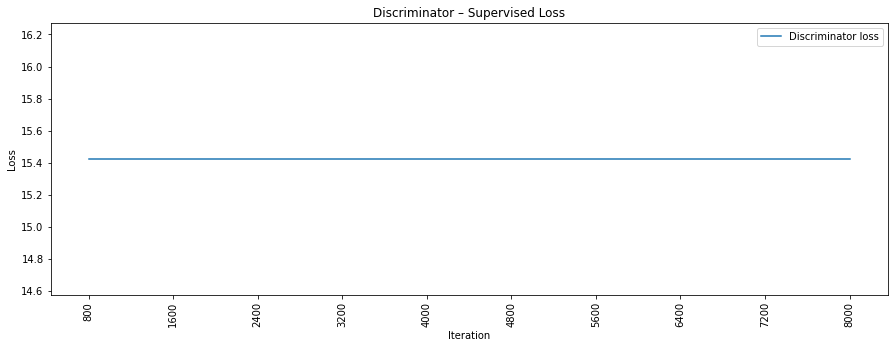

In [41]:
losses = np.array(supervised_losses)

# Plot Discriminator supervised loss
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses, label="Discriminator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Discriminator – Supervised Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

#### SGAN Classifier – Training and Test Accuracy

During training, we see that we achieved supervised accuracy
of 100%. Although this may seem impressive, remember that we have only 100 labeled examples from which to sample for supervised training. Perhaps our model just memorized the training dataset. What matters is how well our classifier can generalize to the previously unseen data in the training set.

In [42]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

# Computes classification accuracy on the test set
_, accuracy = discriminator_supervised.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

313/313 [==============================] - 1s 2ms/step - loss: 2.1384 - accuracy: 0.6468
Test Accuracy: 64.68%


In [43]:
x, y = dataset.training_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the training set
_, accuracy = discriminator_supervised.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

4/4 [==============================] - 0s 6ms/step - loss: 1.9550e-07 - accuracy: 1.0000
Test Accuracy: 100.00%


#### Fully-Supervised Classifier

To make the comparison as fair as possible, we use the same network architecture for the fully supervised classifier as the one used for the supervised Discriminator training.

The idea is that this will allow us to isolate the improvement to the classifier’s ability to generalize that was achieved through the GANenabled
semi-supervised learning.

In [44]:
# Fully supervised classifier with the same network architecture as the SGAN Discriminator
mnist_classifier = build_discriminator_supervised(build_discriminator_net(img_shape))
mnist_classifier.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [45]:
imgs, labels = dataset.training_set()

# One-hot encode labels
labels = to_categorical(labels, num_classes=num_classes)

# Train the classifier
training = mnist_classifier.fit(x=imgs, y=labels, batch_size=32, epochs=30, verbose=1)
losses = training.history['loss']
accuracies = training.history['accuracy']

Epoch 1/30
4/4 [==============================] - 0s 8ms/step - loss: 2.8817 - accuracy: 0.1800
Epoch 2/30
4/4 [==============================] - 0s 4ms/step - loss: 1.4357 - accuracy: 0.5400
Epoch 3/30
4/4 [==============================] - 0s 3ms/step - loss: 0.7504 - accuracy: 0.7800
Epoch 4/30
4/4 [==============================] - 0s 3ms/step - loss: 0.4333 - accuracy: 0.8800
Epoch 5/30
4/4 [==============================] - 0s 3ms/step - loss: 0.3277 - accuracy: 0.8900
Epoch 6/30
4/4 [==============================] - 0s 3ms/step - loss: 0.2331 - accuracy: 0.9500
Epoch 7/30
4/4 [==============================] - 0s 3ms/step - loss: 0.1799 - accuracy: 0.9700
Epoch 8/30
4/4 [==============================] - 0s 4ms/step - loss: 0.1011 - accuracy: 0.9900
Epoch 9/30
4/4 [==============================] - 0s 3ms/step - loss: 0.0979 - accuracy: 0.9800
Epoch 10/30
4/4 [==============================] - 0s 4ms/step - loss: 0.0790 - accuracy: 0.9900
Epoch 11/30
4/4 [======================

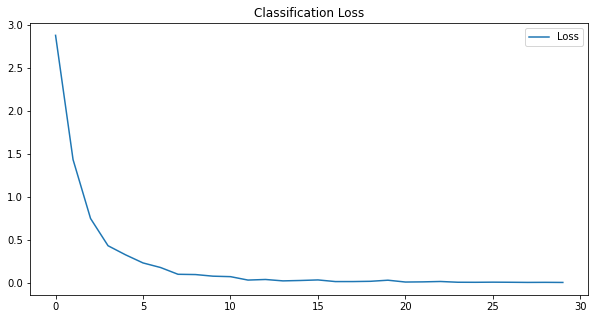

In [46]:
# Plot classification loss
plt.figure(figsize=(10, 5))
plt.plot(np.array(losses), label="Loss")
plt.title("Classification Loss")
plt.legend()

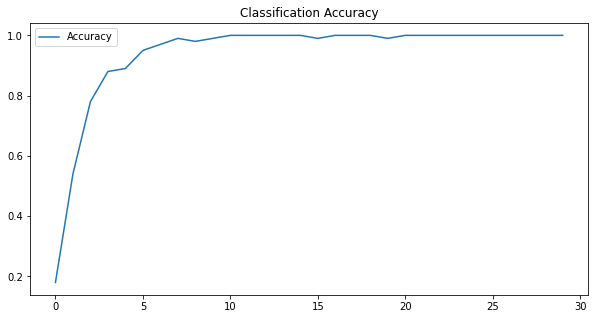

In [47]:
# Plot classification accuracy
plt.figure(figsize=(10, 5))
plt.plot(np.array(accuracies), label="Accuracy")
plt.title("Classification Accuracy")
plt.legend()

In [48]:
x, y = dataset.training_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the training set
_, accuracy = mnist_classifier.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

4/4 [==============================] - 0s 2ms/step - loss: 1.6283 - accuracy: 0.9900
Training Accuracy: 99.00%


In [49]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the test set
_, accuracy = mnist_classifier.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

313/313 [==============================] - 1s 2ms/step - loss: 1.9467 - accuracy: 0.5612
Test Accuracy: 56.12%


Like the SGAN Discriminator, the fully supervised classifier achieved 100% accuracy on the training dataset. On the test set, however, it was able to correctly classify only about 70% of the examples—about a whopping 20 percentage points worse than our SGAN. Put differently, the SGAN improved the training accuracy by almost 30%!

With a lot more training data, the fully supervised classifier’s ability to generalize improves dramatically. Using the same setup and training, the fully supervised classifier with 10,000 labeled examples (100 times as many as we originally used), we achieve an accuracy of about 98%. But that would no longer be a semi-supervised setting.